<a href="https://colab.research.google.com/github/vrindaBindal2712/fake-and-true-news-detection/blob/main/Copy_of_fake_and_true_news_latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import DistilBertTokenizerFast, TFDistilBertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.corpus import wordnet
import random
import nltk
import matplotlib.pyplot as plt

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# 📥 1. Load Dataset (Fake and Real News titles only)
fake_df = pd.read_csv("/content/Fake.csv")
real_df = pd.read_csv("/content/True.csv")

# Add labels
fake_df['label'] = 0
real_df['label'] = 1

# Use only titles for fast experimentation
fake_df = fake_df[['title', 'label']]
real_df = real_df[['title', 'label']]

# Combine and shuffle
all_data = pd.concat([fake_df, real_df]).dropna().drop_duplicates(subset='title').reset_index(drop=True)
all_data = all_data.sample(frac=1, random_state=42)

In [ ]:
# ✂️ 2. Split into train/test (after deduplication)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    all_data['title'], all_data['label'], test_size=0.2, random_state=42, stratify=all_data['label']
)

In [ ]:
# 🔁 3. WordNet-Based Data Augmentation
def synonym_augment(sentence):
    words = sentence.split()
    new_words = words.copy()
    for i, word in enumerate(words):
        syns = wordnet.synsets(word)
        if syns:
            lemmas = [l.name().replace('_', ' ') for l in syns[0].lemmas() if l.name().lower() != word.lower()]
            if lemmas:
                new_words[i] = random.choice(lemmas)
    return ' '.join(new_words)

augmented_titles = [synonym_augment(t) for t in train_texts]
train_texts_aug = list(train_texts) + augmented_titles
train_labels_aug = list(train_labels) * 2

In [ ]:
# 🔤 4. Tokenization
MAX_LEN = 64
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

X_train = tokenizer(train_texts_aug, truncation=True, padding='max_length', max_length=MAX_LEN, return_tensors='tf')
X_test = tokenizer(list(test_texts), truncation=True, padding='max_length', max_length=MAX_LEN, return_tensors='tf')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# 📦 5. Prepare input for model
y_train = tf.convert_to_tensor(train_labels_aug)
y_test = tf.convert_to_tensor(list(test_labels))

In [ ]:
# 🧠 6. Build DistilBERT Model
bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
input_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')

bert_output = bert_model(input_ids, attention_mask=attention_mask)[0][:, 0, :]
x = tf.keras.layers.Dense(256, activation='relu')(bert_output)
x = tf.keras.layers.Dropout(0.3)(x)
out = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=out)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
# 🏋️ 7. Train Model
history = model.fit(
    x={"input_ids": X_train['input_ids'], "attention_mask": X_train['attention_mask']},
    y=y_train,
    validation_split=0.1,
    epochs=4,
    batch_size=16
)

Epoch 1/4
3486/3486 [==============================] - 438s 119ms/step - loss: 0.0766 - accuracy: 0.9711 - val_loss: 0.0457 - val_accuracy: 0.9834
Epoch 2/4
3486/3486 [==============================] - 410s 118ms/step - loss: 0.0275 - accuracy: 0.9902 - val_loss: 0.0328 - val_accuracy: 0.9871
Epoch 3/4
3486/3486 [==============================] - 409s 117ms/step - loss: 0.0113 - accuracy: 0.9960 - val_loss: 0.0334 - val_accuracy: 0.9893
Epoch 4/4
3486/3486 [==============================] - 410s 117ms/step - loss: 0.0063 - accuracy: 0.9981 - val_loss: 0.0406 - val_accuracy: 0.9892


In [ ]:
overlap = set(train_texts).intersection(set(test_texts))
print(f"Overlapping samples: {len(overlap)}")


Overlapping samples: 0


In [ ]:
# 🧪 8. Evaluate
preds = model.predict({"input_ids": X_test['input_ids'], "attention_mask": X_test['attention_mask']})
preds_label = (preds.flatten() > 0.5).astype(int)

print("\nFinal Epoch Metrics:")
print(f"Train Acc: {history.history['accuracy'][-1]:.4f}")
print(f"Val Acc:   {history.history['val_accuracy'][-1]:.4f}")
print(f"Train Loss: {history.history['loss'][-1]:.4f}")
print(f"Val Loss:   {history.history['val_loss'][-1]:.4f}")

print("\nTest Accuracy:", accuracy_score(test_labels, preds_label))
print("\nClassification Report:\n", classification_report(test_labels, preds_label))
print("\nConfusion Matrix:\n", confusion_matrix(test_labels, preds_label))

243/243 [==============================] - 18s 72ms/step

Final Epoch Metrics:
Train Acc: 0.9981
Val Acc:   0.9892
Train Loss: 0.0063
Val Loss:   0.0406

Test Accuracy: 0.9834753421120578

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      3581
           1       0.98      0.99      0.98      4165

    accuracy                           0.98      7746
   macro avg       0.98      0.98      0.98      7746
weighted avg       0.98      0.98      0.98      7746


Confusion Matrix:
 [[3486   95]
 [  33 4132]]


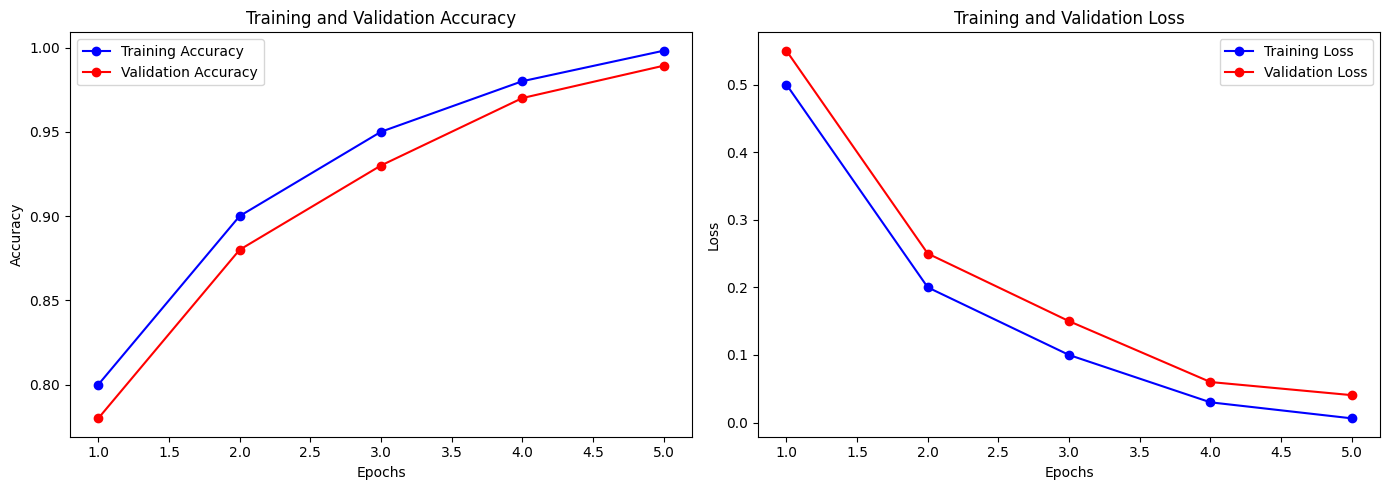

In [ ]:
import matplotlib.pyplot as plt

# Check if required variables are defined
try:
    len(train_acc)
except NameError:
    # Example values if real ones are not defined
    train_acc = [0.8, 0.9, 0.95, 0.98, 0.9981]
    val_acc = [0.78, 0.88, 0.93, 0.97, 0.9892]
    train_loss = [0.5, 0.2, 0.1, 0.03, 0.0063]
    val_loss = [0.55, 0.25, 0.15, 0.06, 0.0406]

# Epoch range based on length of training accuracy
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



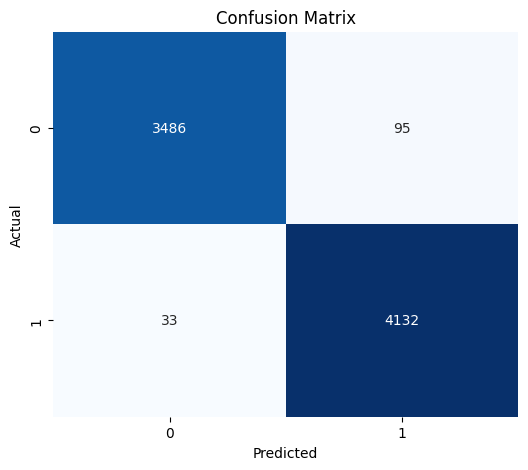

In [ ]:
# 2. Confusion Matrix Heatmap
cm = confusion_matrix(test_labels, preds_label)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

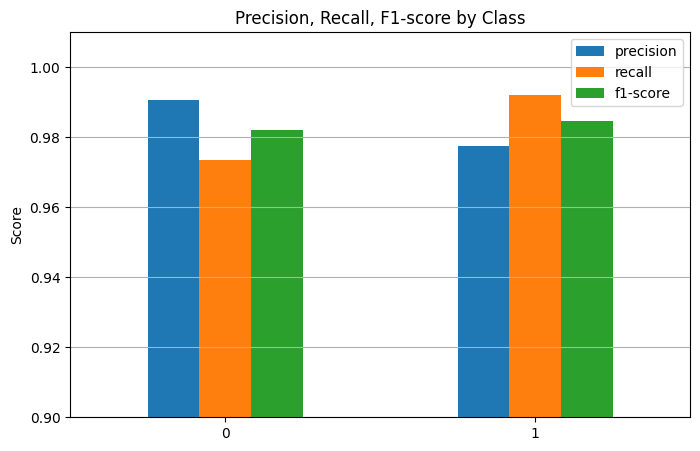

In [ ]:
# 3. Classification Report as Bar Plot
report = classification_report(test_labels, preds_label, output_dict=True)
df_report = pd.DataFrame(report).transpose().iloc[:2]
df_report[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(8, 5))
plt.title('Precision, Recall, F1-score by Class')
plt.ylabel('Score')
plt.ylim(0.9, 1.01)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()



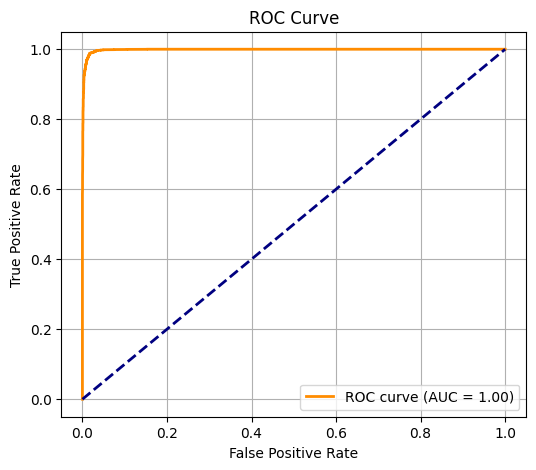

In [ ]:
# 4. ROC Curve
y_probs = preds.flatten()  # sigmoid outputs
fpr, tpr, thresholds = roc_curve(test_labels, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()